In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

# Datasets & Loading Them

In [2]:
def generate_covid19_us_dataset():
    output_data = []
    date_number = 0
    for date in pd.date_range(datetime(year=2020, month=4, day=12), datetime(year=2020, month=7, day=16)):
        raw_report_data = pd.read_csv(f'../data/covid19/jhu-us-reports/{date.month:02}-{date.day:02}-{date.year}.csv')
        for i, item in raw_report_data.iterrows():
            output_data.append({
                'date': date,
                'date_number': date_number,
                'country': item['Country_Region'],
                'state': item['Province_State'],
                'fips': item['FIPS'],
                'total_confirmed': item['Confirmed'],
                'total_deaths': item['Deaths'],
                'total_recovered': item['Recovered'],
                'total_hospitalized': item['People_Hospitalized'],
                'total_tested': item['People_Tested'],
                'active': item['Active'],
                'tests_rate': item['Testing_Rate'],
                'hospitalize_rate': item['Hospitalization_Rate'],
                'mortality_rate': item['Mortality_Rate'],
                'incident_rate': item['Incident_Rate'],
            })
        
        date_number += 1
            
    output_df = pd.DataFrame(output_data)
    output_df.to_csv('../data/covid19/us.csv', index=False)
    return output_df

def load_covid19_us_dataset():
    return pd.read_csv('../data/covid19/us.csv')

In [3]:
generate_covid19_us_dataset()
us_data = load_covid19_us_dataset()
us_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5586 entries, 0 to 5585
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                5586 non-null   object 
 1   date_number         5586 non-null   int64  
 2   country             5586 non-null   object 
 3   state               5586 non-null   object 
 4   fips                5567 non-null   float64
 5   total_confirmed     5586 non-null   int64  
 6   total_deaths        5586 non-null   int64  
 7   total_recovered     4199 non-null   float64
 8   total_hospitalized  3575 non-null   float64
 9   total_tested        5376 non-null   float64
 10  active              5569 non-null   float64
 11  tests_rate          5376 non-null   float64
 12  hospitalize_rate    3575 non-null   float64
 13  mortality_rate      5472 non-null   float64
 14  incident_rate       5376 non-null   float64
dtypes: float64(9), int64(3), object(3)
memory usage: 654.7+

# Plotting

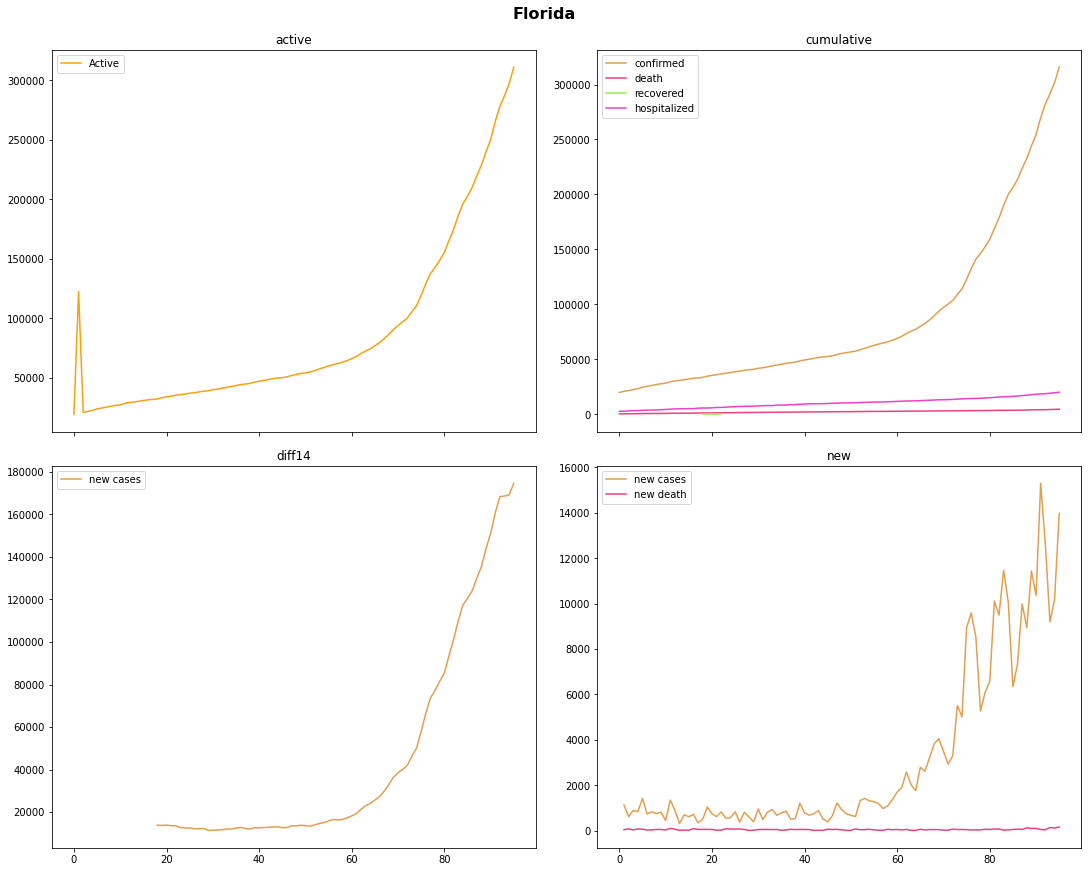

In [4]:
def plot_us_state_active(ax, state_data):
    ax.plot(state_data['date_number'], state_data['active'], color='#faa00f', label='Active')

def plot_us_state_total_tested(ax, state_data):
    ax.plot(state_data['date_number'], state_data['total_tested'], color='#f2f077', label='tested')

def plot_us_state_total_confirmed(ax, state_data):
    ax.plot(state_data['date_number'], state_data['total_confirmed'], color='#e39e4f', label='confirmed')

def plot_us_state_total_recovered(ax, state_data):
    ax.plot(state_data['date_number'], state_data['total_recovered'], color='#8ff041', label='recovered')

def plot_us_state_total_death(ax, state_data):
    ax.plot(state_data['date_number'], state_data['total_deaths'], color='#f23d7f', label='death')

def plot_us_state_total_hospitalized(ax, state_data):
    ax.plot(state_data['date_number'], state_data['total_hospitalized'], color='#f03ec9', label='hospitalized')

def plot_us_new_confirmed(ax, state_data):
    new_confirmed = state_data['total_confirmed'].diff()
    ax.plot(state_data['date_number'], new_confirmed, color='#e39e4f', label='new cases')

def plot_us_new_death(ax, state_data):
    new_death = state_data['total_deaths'].diff()
    ax.plot(state_data['date_number'], new_death, color='#f23d7f', label='new death')

def plot_us_diff14(ax, state_data):
    new_confirmed = state_data['total_confirmed'].diff(18)
    ax.plot(state_data['date_number'], new_confirmed, color='#e39e4f', label='new cases')

def plot_us_state_data(state):
    state_data = us_data[us_data['state'] == state]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True, sharex=True, figsize=(15,12))
    
    plot_us_state_active(ax1, state_data)
    
    plot_us_state_total_confirmed(ax2, state_data)
    plot_us_state_total_death(ax2, state_data)
    plot_us_state_total_recovered(ax2, state_data)
    plot_us_state_total_hospitalized(ax2, state_data)
    
    #plot_us_state_total_tested(ax3, state_data)
    plot_us_diff14(ax3, state_data)
    
    plot_us_new_confirmed(ax4, state_data)
    plot_us_new_death(ax4, state_data)
    
    fig.suptitle(f'{state}', fontsize=16, fontweight='bold')
    
    ax1.set(title=f'active')
    ax1.legend()
    
    ax2.set(title=f'cumulative')
    ax2.legend()
    
    ax3.set(title=f'diff14')
    ax3.legend()
    
    ax4.set(title=f'new')
    ax4.legend()
    
    plt.show()

plot_us_state_data('Florida')

# SCIR Model

In [5]:
def scir(population, initial_carriers, initial_infected, initial_dead, n, alpha, beta, gamma, zeta, eta, epsilon, delta):
    index = [0]
    susceptiple = [population - initial_infected - initial_carriers]
    carrier = [initial_carriers]
    infected = [initial_infected]
    recovered = [0]
    dead = [initial_dead]
    
    for t in range(1, n):
        new_carriers = (alpha*susceptiple[t-1]*carrier[t-1]) + (beta*susceptiple[t-1]*infected[t-1])
        new_infected = gamma*carrier[t-1]
        new_dead = (zeta*carrier[t-1]) + (epsilon*infected[t-1])
        new_recovered = (eta*carrier[t-1]) + (delta*infected[t-1])
        
        gone_susceptiple = new_carriers
        gone_carrier = (gamma*carrier[t-1]) + (zeta*carrier[t-1]) + (eta*carrier[t-1])
        gone_infected = (epsilon*infected[t-1]) + (delta*infected[t-1])
        
        index.append(t)
        susceptiple.append(susceptiple[t-1] - gone_susceptiple)
        carrier.append(carrier[t-1] + new_carriers - gone_carrier)
        infected.append(infected[t-1] + new_infected - gone_infected)
        dead.append(dead[t-1] + new_dead)
        recovered.append(recovered[t-1] + new_recovered)
    
    return pd.DataFrame({'date_number': index, 'susceptiple': susceptiple, 'carrier': carrier, 'infected': infected, 'recovered': recovered, 'dead': dead}, index=index)        

In [6]:
def timed_scir(population, initial_carriers, initial_infected, initial_dead, n, alpha, beta, gamma, zeta, eta, epsilon, delta):
    index = [0]
    susceptiple = [population - initial_infected - initial_carriers]
    carrier = [initial_carriers]
    infected = [initial_infected]
    recovered = [0]
    dead = [initial_dead]
    
    for t in range(1, n):
        carrier_to_infected = max(min(gamma * carrier[t-7], carrier[t-1]), 0) if t >= 7 else 0
        carrier_to_dead = max(min(zeta*carrier[t-14], carrier[t-1] - carrier_to_infected), 0) if t >= 14 else 0
        carrier_to_recovered = max(min(eta*carrier[t-14], carrier[t-1] - carrier_to_infected - carrier_to_dead), 0) if t >= 14 else 0
        infected_to_dead = max(min(epsilon*infected[t-14], infected[t-1]), 0) if t >= 14 else 0
        infected_to_recovered = max(min(delta*infected[t-14], infected[t-1] - infected_to_dead), 0) if t >= 14 else 0
        
        asus = alpha*susceptiple[t-1]
        bsus = beta*susceptiple[t-1]
        new_carriers = (asus*carrier[t-1]) + (bsus*infected[t-1])
        new_infected = carrier_to_infected
        new_dead = carrier_to_dead + infected_to_dead
        new_recovered = carrier_to_recovered + infected_to_recovered
        
        gone_susceptiple = new_carriers
        gone_carrier = carrier_to_infected + carrier_to_dead + carrier_to_recovered
        gone_infected = infected_to_recovered + infected_to_recovered
        
        index.append(t)
        susceptiple.append(susceptiple[t-1] - gone_susceptiple)
        carrier.append(carrier[t-1] + new_carriers - gone_carrier)
        infected.append(infected[t-1] + new_infected - gone_infected)
        dead.append(dead[t-1] + new_dead)
        recovered.append(recovered[t-1] + new_recovered)
    
    return pd.DataFrame({'date_number': index, 'susceptiple': susceptiple, 'carrier': carrier, 'infected': infected, 'recovered': recovered, 'dead': dead}, index=index)        

In [7]:
def plot_scir(scir_output):
    plt.plot(scir_output['date_number'], scir_output['infected'], color='#FFC182',label='infected')
    plt.plot(scir_output['date_number'], scir_output['dead'], color='#F8CECC',label='dead')
    plt.legend()
    plt.show()

In [8]:
def sir(population, initial_infected, initial_dead, beta, gamma, rounds=100):
    index = [0]
    susceptiple = [population - initial_infected]
    infected = [initial_infected]
    dead = [initial_dead]
    
    for t in range(1, rounds):
        index.append(t)
        new_infected = beta * (susceptiple[t-1]/population) * infected[t-1]
        new_dead = gamma * infected[t-1]
        susceptiple.append(susceptiple[t-1] - new_infected)
        infected.append(infected[t-1] + new_infected - new_dead)
        dead.append(dead[t-1]+new_dead)
        
    return pd.DataFrame({'date_number': index, 'susceptiple': susceptiple, 'infected': infected, 'removed': dead}, index=index)        

nan


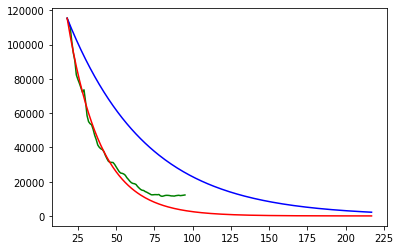

,date,date_number,country,state,fips,total_confirmed,total_deaths,total_recovered,total_hospitalized,total_tested,active,tests_rate,hospitalize_rate,mortality_rate,incident_rate
35,2020-04-12,0,US,New York,36.0,189033,9385,23887.0,42594.0,461601.0,179648.0,2737.680538,22.532574,4.964742,1121.124012
95,2020-04-13,1,US,New York,36.0,195749,10058,23887.0,42712.0,478357.0,185691.0,2837.057652,21.819779,5.138213,1160.955517
154,2020-04-14,2,US,New York,36.0,203020,10842,23887.0,46201.0,499143.0,192178.0,2960.336041,22.756871,5.340361,1204.078637
213,2020-04-15,3,US,New York,36.0,214454,11617,23887.0,46201.0,526012.0,202837.0,3119.691715,21.543548,5.417013,1271.891833
272,2020-04-16,4,US,New York,36.0,223691,14832,23887.0,50450.0,550579.0,208859.0,3265.394601,22.553433,6.630575,1326.674980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,2020-07-12,91,US,New York,36.0,401706,32350,71565.0,89995.0,4673195.0,297791.0,24022.311391,22.403200,8.053153,2064.948417
5390,2020-07-13,92,US,New York,36.0,402263,32395,71643.0,89995.0,4724882.0,298225.0,24288.005677,22.372179,8.053189,2067.811646
5448,2020-07-14,93,US,New York,36.0,403175,32408,71692.0,89995.0,4784927.0,299075.0,24596.663819,22.321573,8.038197,2072.499734
5506,2020-07-15,94,US,New York,36.0,404006,32427,71782.0,89995.0,4848525.0,299797.0,24923.585970,22.275659,8.026366,2076.771446


In [9]:
state = 'New York'
state_data = us_data[us_data['state'] == state]

RECOVERY_DAYS = 18

def plot_recovery_diff(ax, state_data):
    new_confirmed = state_data['total_confirmed'].diff(RECOVERY_DAYS)
    print(new_confirmed.iloc[14])
    ax.plot(state_data['date_number'], new_confirmed, color='g', label='prediction')

def plot_prediction(ax, predicted_data, color='b'):
    ax.plot(predicted_data['date_number'] + RECOVERY_DAYS, predicted_data['infected'], color=color, label='real')

initial_infected = state_data['total_confirmed'].diff(RECOVERY_DAYS).iloc[RECOVERY_DAYS]
    
predicted_data1 = sir(8.4e6, initial_infected, 0, 0.037, 1/RECOVERY_DAYS, 200)
predicted_data2 = sir(8.4e6, initial_infected, 0, 0.010, 1/RECOVERY_DAYS, 200)

plot_recovery_diff(plt, state_data)
plot_prediction(plt, predicted_data1, 'b')
plot_prediction(plt, predicted_data2, 'r')
plt.show()

state_data

## Google Mobility Data

In [18]:
mobility_data = pd.read_csv('../data/mobility/googlereport.csv', low_memory=False)
mobility_data[mobility_data['sub_region_1'] == 'New York']

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
473091,US,United States,New York,NaN,US-NY,NaN,2020-02-15,3.0,-4.0,-2.0,-4.0,1.0,0.0
473092,US,United States,New York,NaN,US-NY,NaN,2020-02-16,7.0,-3.0,13.0,0.0,0.0,-1.0
473093,US,United States,New York,NaN,US-NY,NaN,2020-02-17,7.0,-2.0,23.0,-22.0,-37.0,9.0
473094,US,United States,New York,NaN,US-NY,NaN,2020-02-18,-2.0,-5.0,-4.0,-5.0,-10.0,3.0
473095,US,United States,New York,NaN,US-NY,NaN,2020-02-19,3.0,-2.0,11.0,-3.0,-9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
482014,US,United States,New York,Yates County,NaN,36123.0,2020-07-03,NaN,NaN,NaN,NaN,-48.0,NaN
482015,US,United States,New York,Yates County,NaN,36123.0,2020-07-04,NaN,NaN,NaN,NaN,-23.0,NaN
482016,US,United States,New York,Yates County,NaN,36123.0,2020-07-05,NaN,NaN,NaN,NaN,-13.0,NaN
482017,US,United States,New York,Yates County,NaN,36123.0,2020-07-06,NaN,46.0,NaN,NaN,-31.0,NaN
